# Forecasting the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 60/20/20
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price

----
### Model evaluation (Test set)
- RMSE: 224.95
- MAE: 176.14
- MAPE: 1.60 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> ITD - 6 2 2
split = 1  # 6 2 2
stock = 2  # ITD

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1308,2024-05-27,11300,11600,11300,11300,47400,ITD
1309,2024-05-28,11650,12050,11400,12050,322600,ITD
1310,2024-05-29,12850,12850,12450,12600,334600,ITD
1311,2024-05-30,12600,12600,12100,12500,299000,ITD


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [39]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [40]:
# Shape of the dataframe
df.shape

(1313, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,9972.168317,10160.894897
std,2917.997297,3002.802575
min,5130.000000,5320.000000
25%,7460.000000,7550.000000
50%,9900.000000,10040.000000
75%,11500.000000,11650.000000
max,20700.000000,21430.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

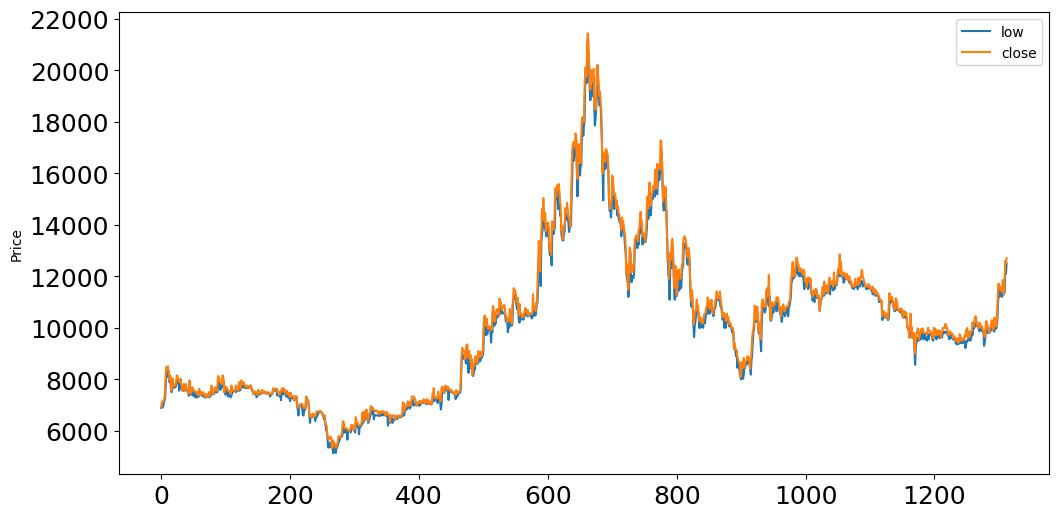

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.584523707127448,
 0.4913629480785365,
 12,
 1300,
 {'1%': -3.435390199468821,
  '5%': -2.8637658312426035,
  '10%': -2.567955046745562},
 18249.61406238007)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.656
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.600
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


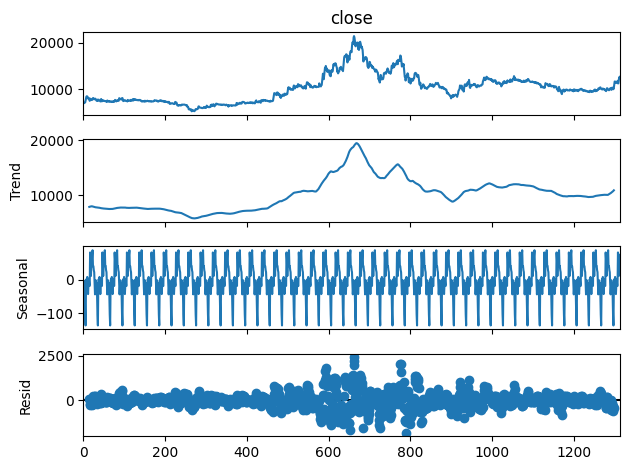

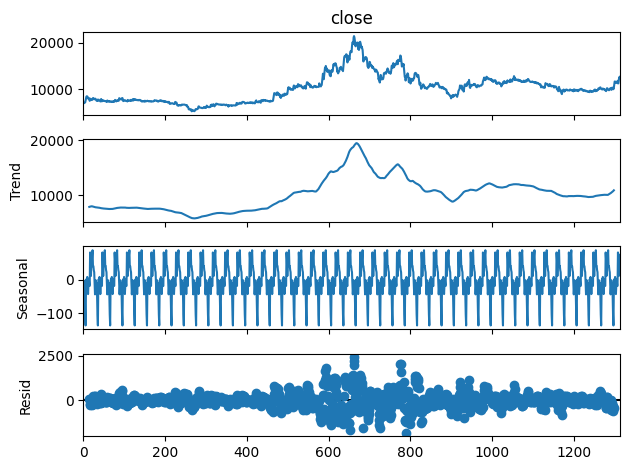

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-8.108700059106322,
 1.242600910378811e-12,
 11,
 774,
 {'1%': -3.4388268991356936,
  '5%': -2.8652813916285518,
  '10%': -2.5687622857867782},
 10910.351288877293)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

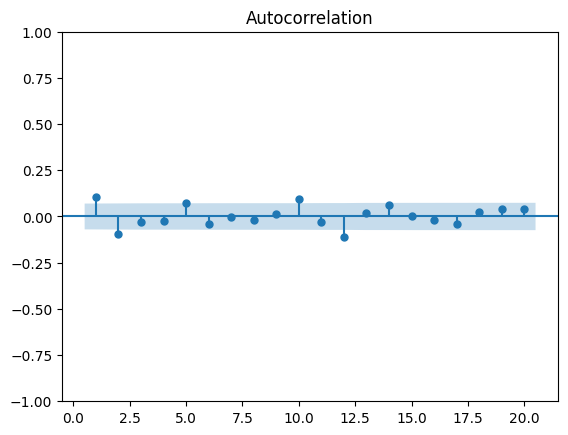

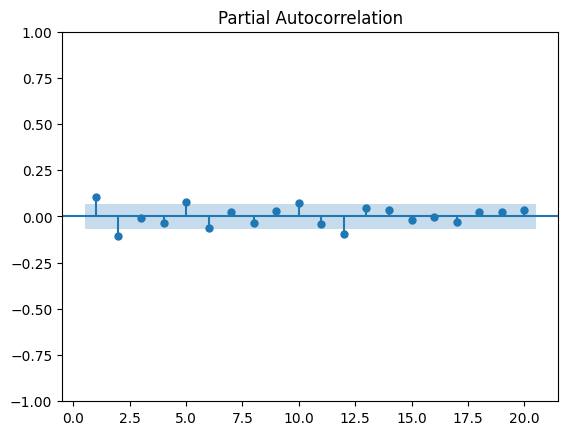

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=11217.061, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=11235.038, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=11224.029, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=11222.485, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=11233.491, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=11219.624, Time=0.56 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=11218.557, Time=0.36 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=11213.369, Time=0.93 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=11215.061, Time=0.84 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=11215.378, Time=0.91 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=11214.899, Time=0.85 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=11211.644, Time=0.79 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=11216.373, Time=0.47 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=11214.311, Time=0.50 sec
 ARIMA(1,1,2)(2,0,2)[5] intercept   : AIC=11212.749, Time=0.93

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  787
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 5)   Log Likelihood               -5599.012
Date:                             Mon, 03 Jun 2024   AIC                          11210.024
Time:                                     21:37:56   BIC                          11238.026
Sample:                                          0   HQIC                         11220.790
                                             - 787                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1299      0.025      5.299      0.000       0.082       0.178
ma.L2         -0.0782      

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(2, 0, 1, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([12380.49121258, 12202.31873283, 11298.43872705, 12599.72512687,
       12734.48689506, 12594.83868719, 13485.41176187, 13100.38707325,
       12678.36673456, 11811.60401572, 11346.10304763, 12267.89221895,
       12267.57535297, 11488.18617048, 11611.62132711, 11900.10526759,
       12456.4594887 , 11710.73161315, 12174.44606871, 12040.83961153,
       11814.32517626, 12317.41542289, 12635.02030468, 12690.75405166,
       13466.04274098, 13560.26215567, 13434.04100138, 13381.20756289,
       13427.33275604, 12835.36759358, 12730.98165623, 13009.99153155,
       13011.89039482, 12874.09274649, 11989.21328589, 11299.15198633,
       11071.06123166, 11395.09048618, 11013.44818976, 10380.72078792,
        9868.93068189, 10321.1034545 , 10465.59145713, 10745.37595412,
       10919.77958887, 11064.89918004, 10928.4605639 , 10743.23396661,
       10229.19535475, 10513.11550105, 10235.59120396, 10321.11110866,
       10282.26084093, 10470.36705716, 10227.19837854, 10463.97883108,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([12085.12013959, 12395.83771169, 12479.923019  , 12436.76177626,
       12225.2264244 , 12370.76408009, 12589.1133335 , 12265.19990135,
       12362.62524274, 12269.93843932, 12018.32686891, 12064.18803069,
       12216.64930591, 12221.52124825, 12161.62263543, 12164.92071234,
       12171.27362512, 12118.13998968, 12164.2608593 , 12020.4691927 ,
       12068.95541159, 11960.93309342, 11962.7964834 , 11814.82604211,
       11856.77965367, 11859.33218363, 11763.66665758, 11863.6113603 ,
       11858.81050638, 11918.69874637, 11865.23885609, 11909.9889149 ,
       11759.10963698, 11967.6091087 , 11907.73161058, 11859.33850406,
       12120.13780123, 11965.46221333, 12062.52475934, 12071.46555054,
       11865.23172691, 11960.92217006, 12013.74328796, 11967.60108372,
       11856.8188549 , 11757.49342015, 11865.49982993, 11761.75490795,
       11858.82886088, 11816.82230596, 11814.29866303, 11808.15168301,
       11759.11620587, 11712.96260559, 11754.97979055, 11553.79623831,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[21369.78114665 21438.47202325 21331.45668213 21351.8250263
 21356.59740253 21412.88650393 21440.13510891 21434.381499
 21442.55828609 21464.32711664 21479.9493214  21487.48797594
 21499.7746498  21517.25013197 21520.88110606 21536.7827228
 21555.73917542 21566.13512689 21573.93348927 21595.52350371
 21605.68721537 21612.12053117 21626.58746098 21643.99870073
 21647.62980505 21662.78587486 21681.57598278 21692.2721312
 21700.07481711 21721.64054987]


### Plotting the data


In [67]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

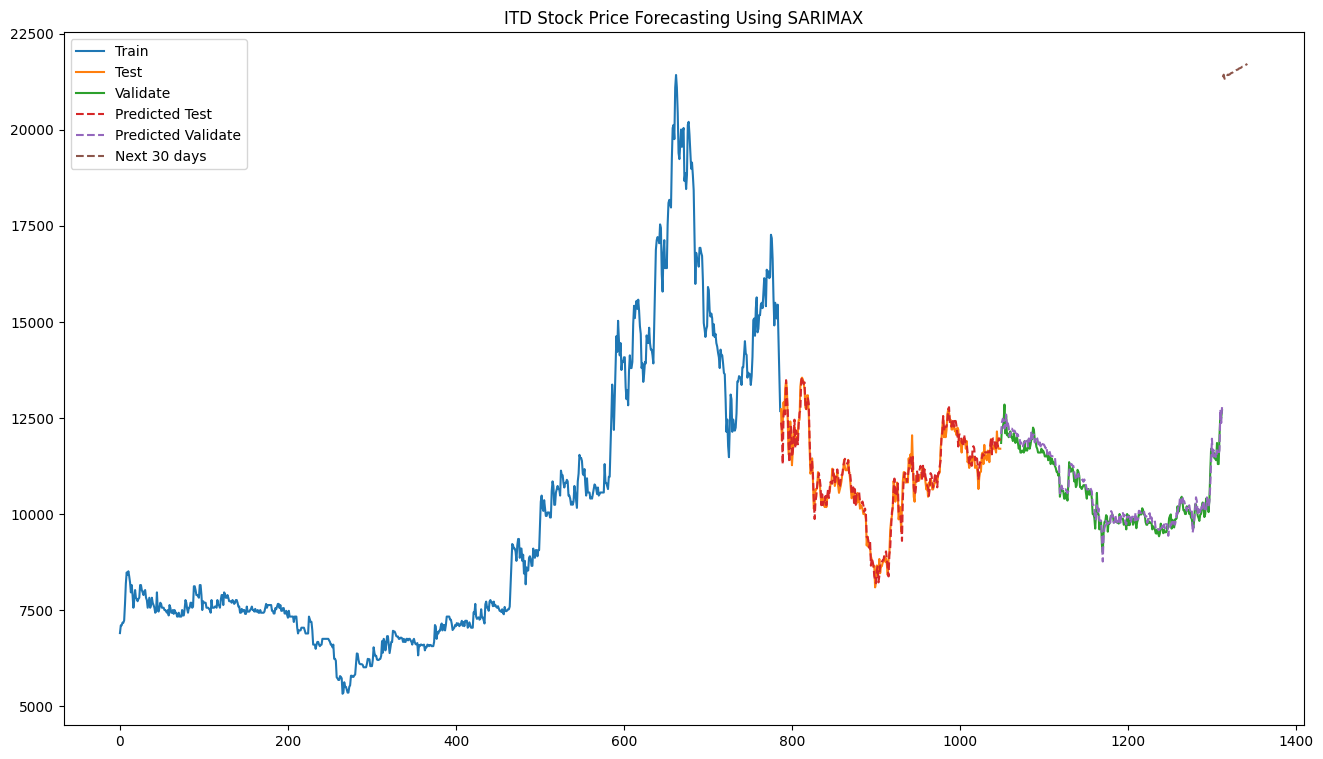

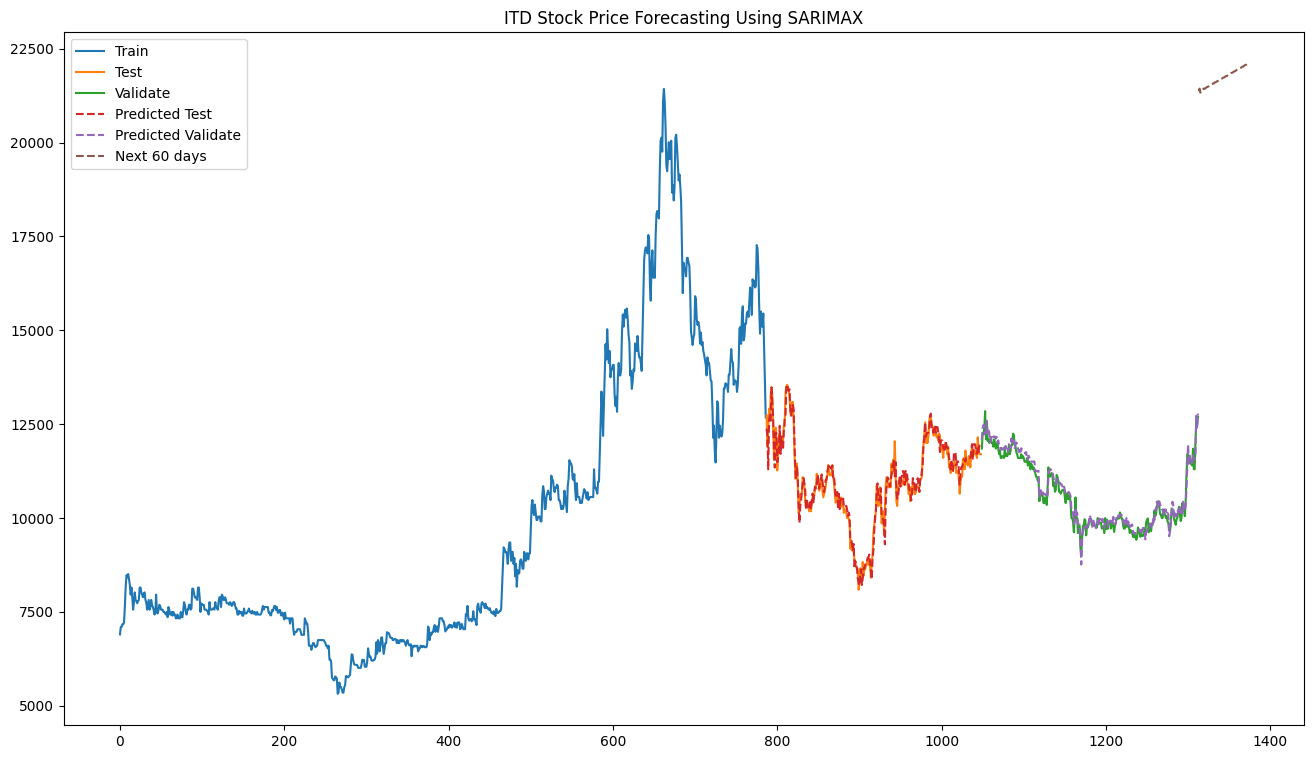

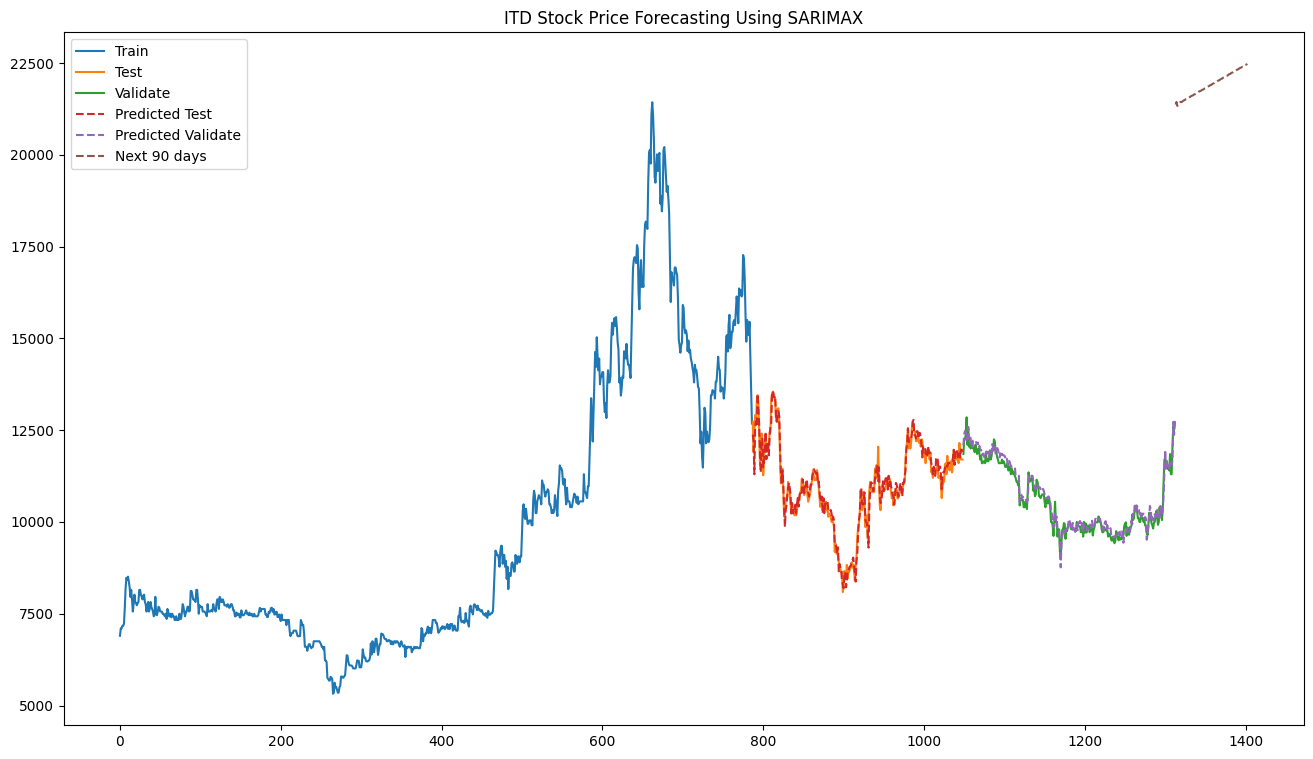

In [68]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 224.9554480863529
MAE on test data: 176.13651490831742
MAPE on test data: 1.6032408953631176 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 172.8353749453087
MAE on validation data: 147.82610041764335
MAPE on validation data: 1.390187462914979 %
